In [1]:
import zarr
import os
import matplotlib.pyplot as plt

In [2]:
ZARR_TEST_FOLDER = '../../../../data/cells/raw/zarr/test/'


In [3]:
files = os.listdir(ZARR_TEST_FOLDER)
files = [os.path.join(ZARR_TEST_FOLDER,f) for f in files ]
print(files)

['../../../../data/cells/raw/zarr/test/20072019_ND9_ND11_DIV0-1_Daam1_aTub_Phallo_18_ch_4.zarr']


In [4]:
TEST_PATH = files[0]
zarr_file = zarr.open(TEST_PATH, mode='r')
zarr_file.info

Name,/
Type,zarr.hierarchy.Group
Read-only,True
Store type,zarr.storage.DirectoryStore
No. members,9
No. arrays,9
No. groups,0
Arrays,"ground_truth, instances, pred_v1, pred_v2, pred_v3, pred_v4, pred_v5, pred_v6, raw"


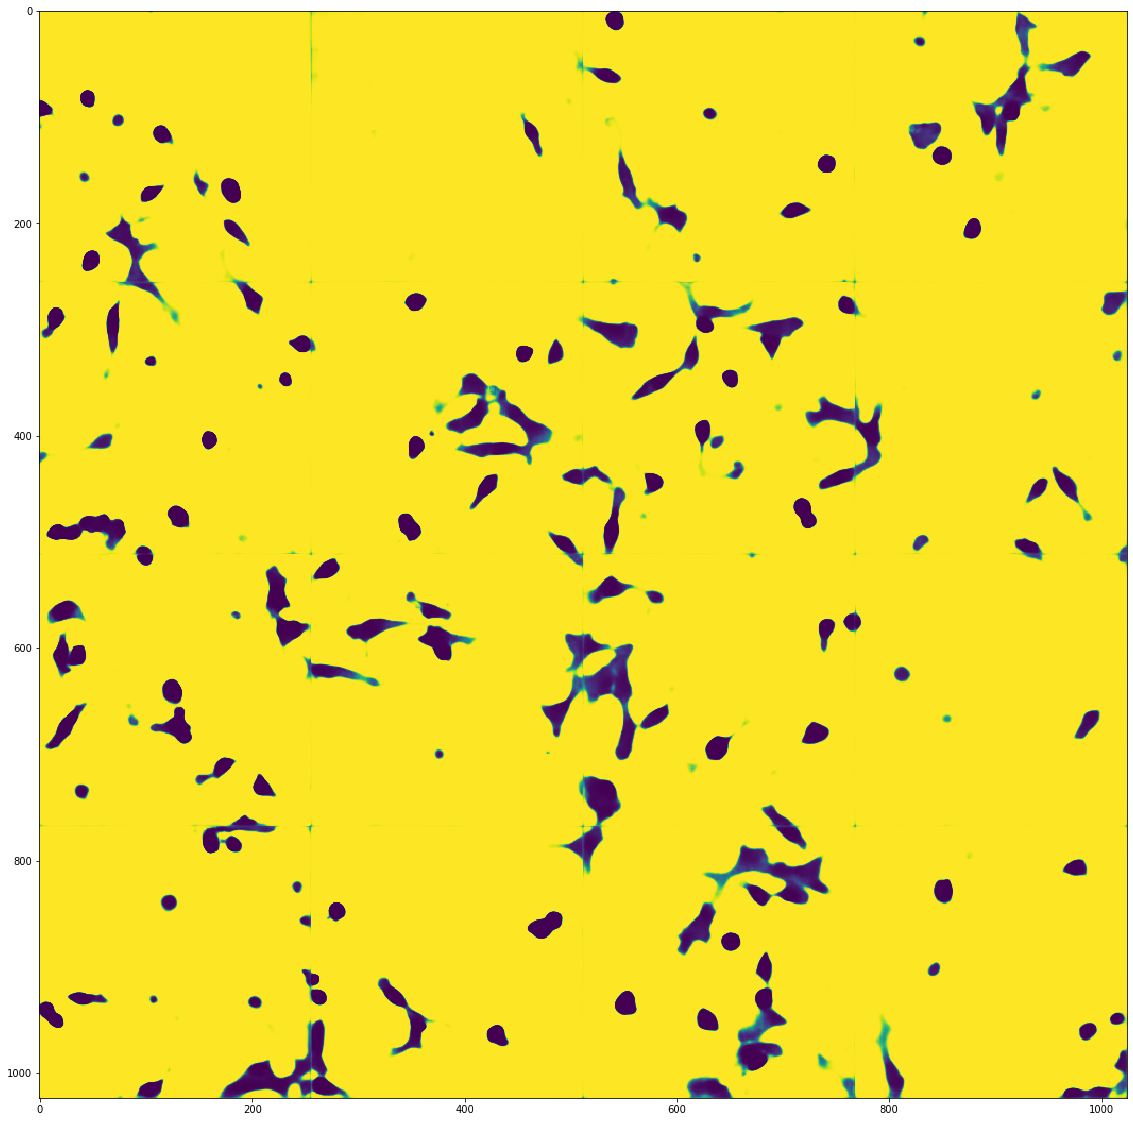

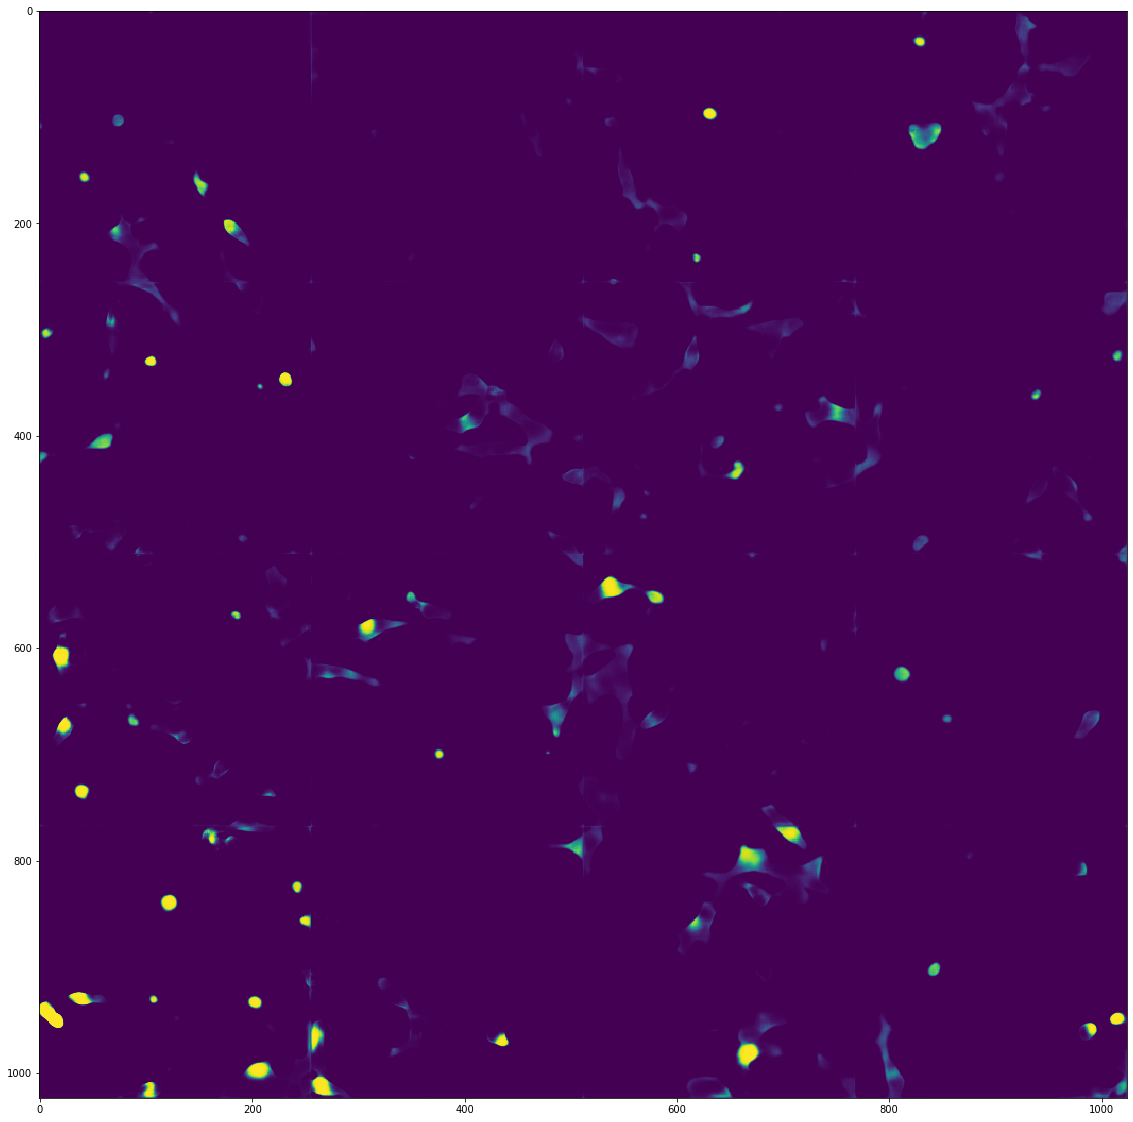

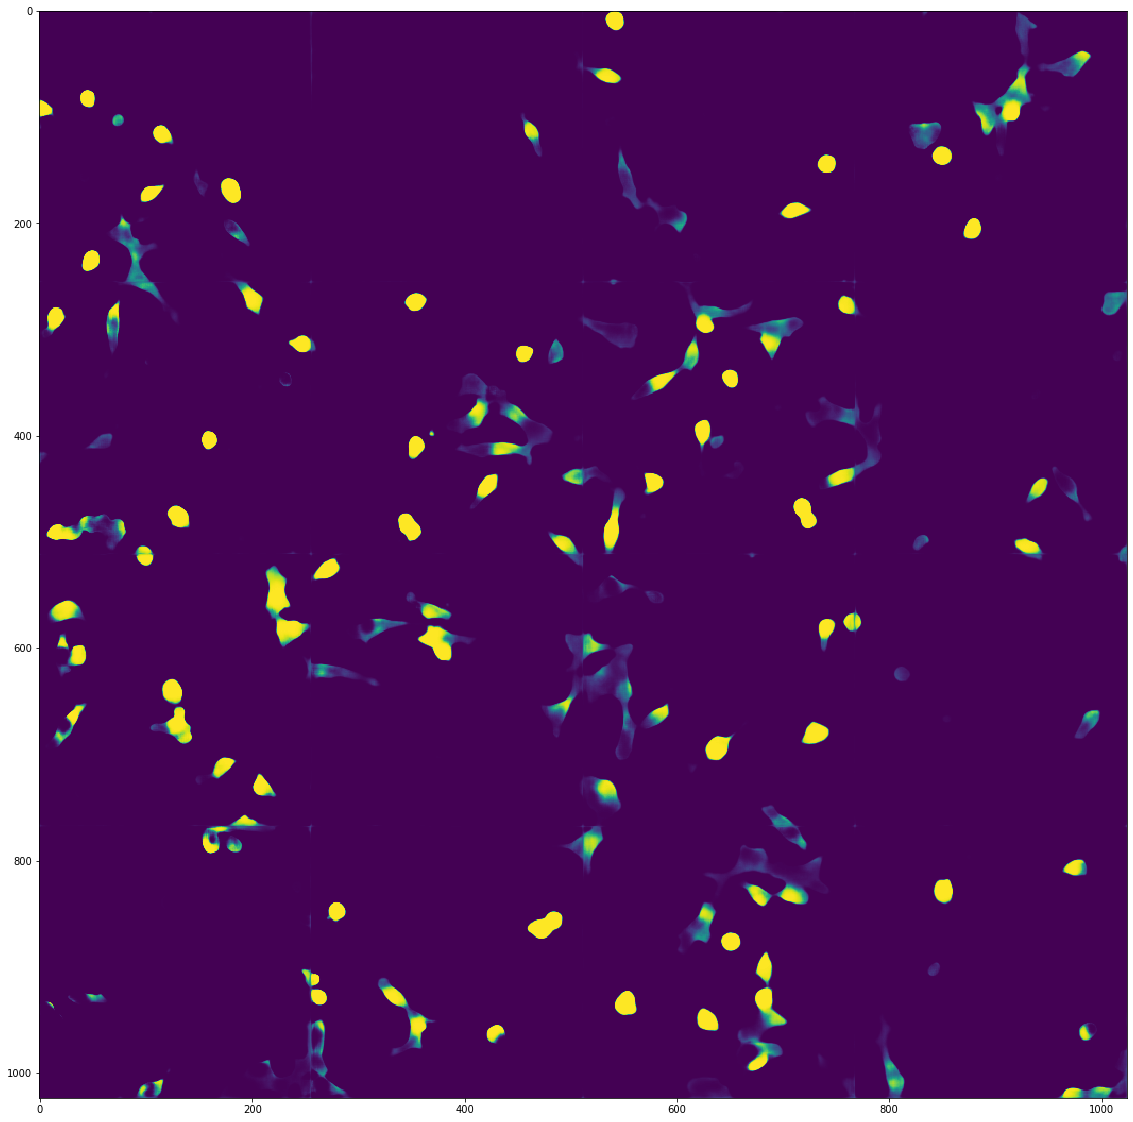

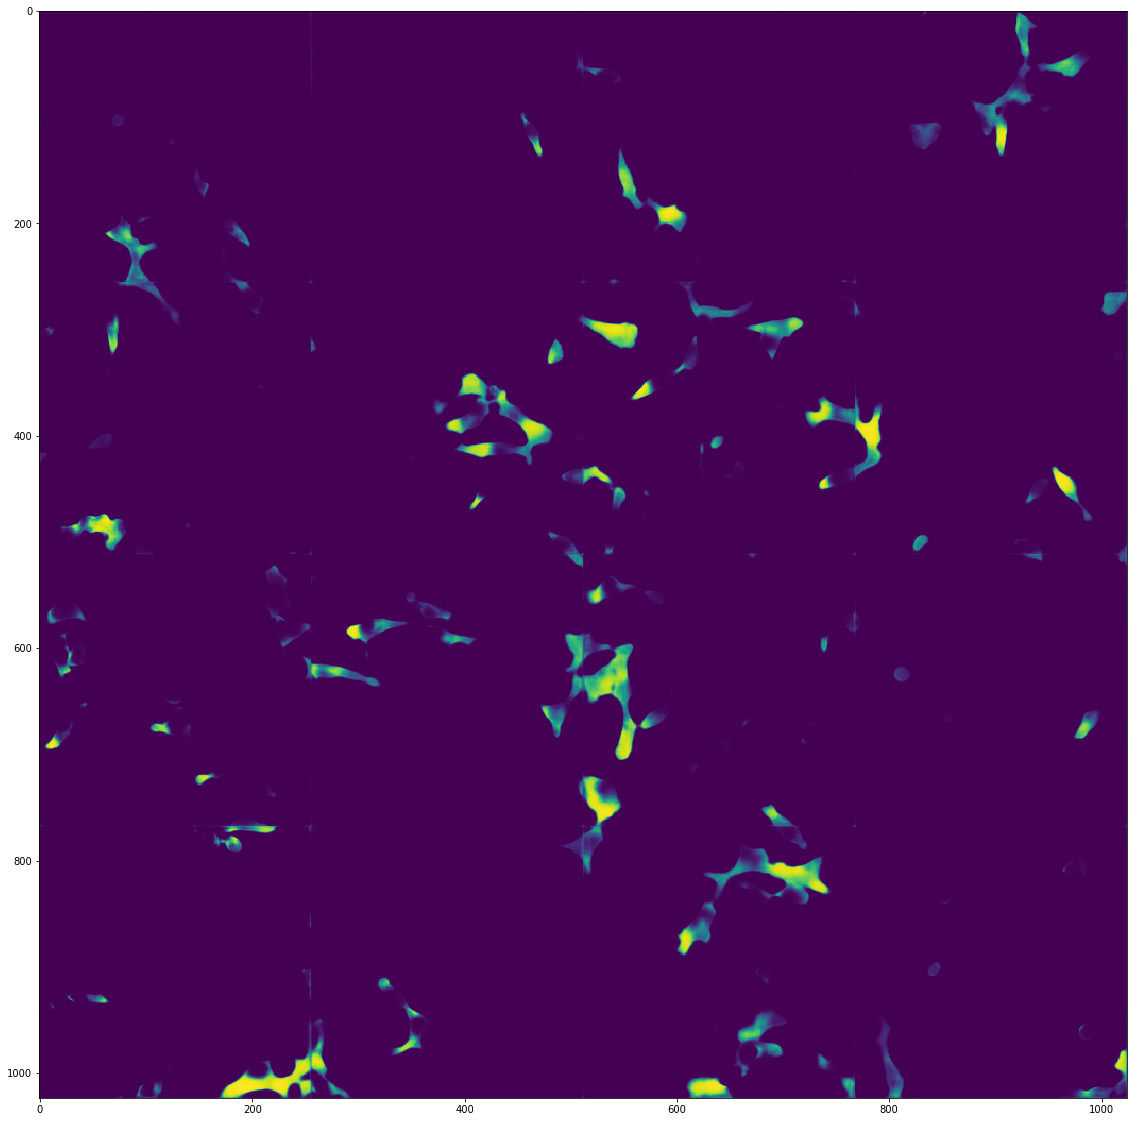

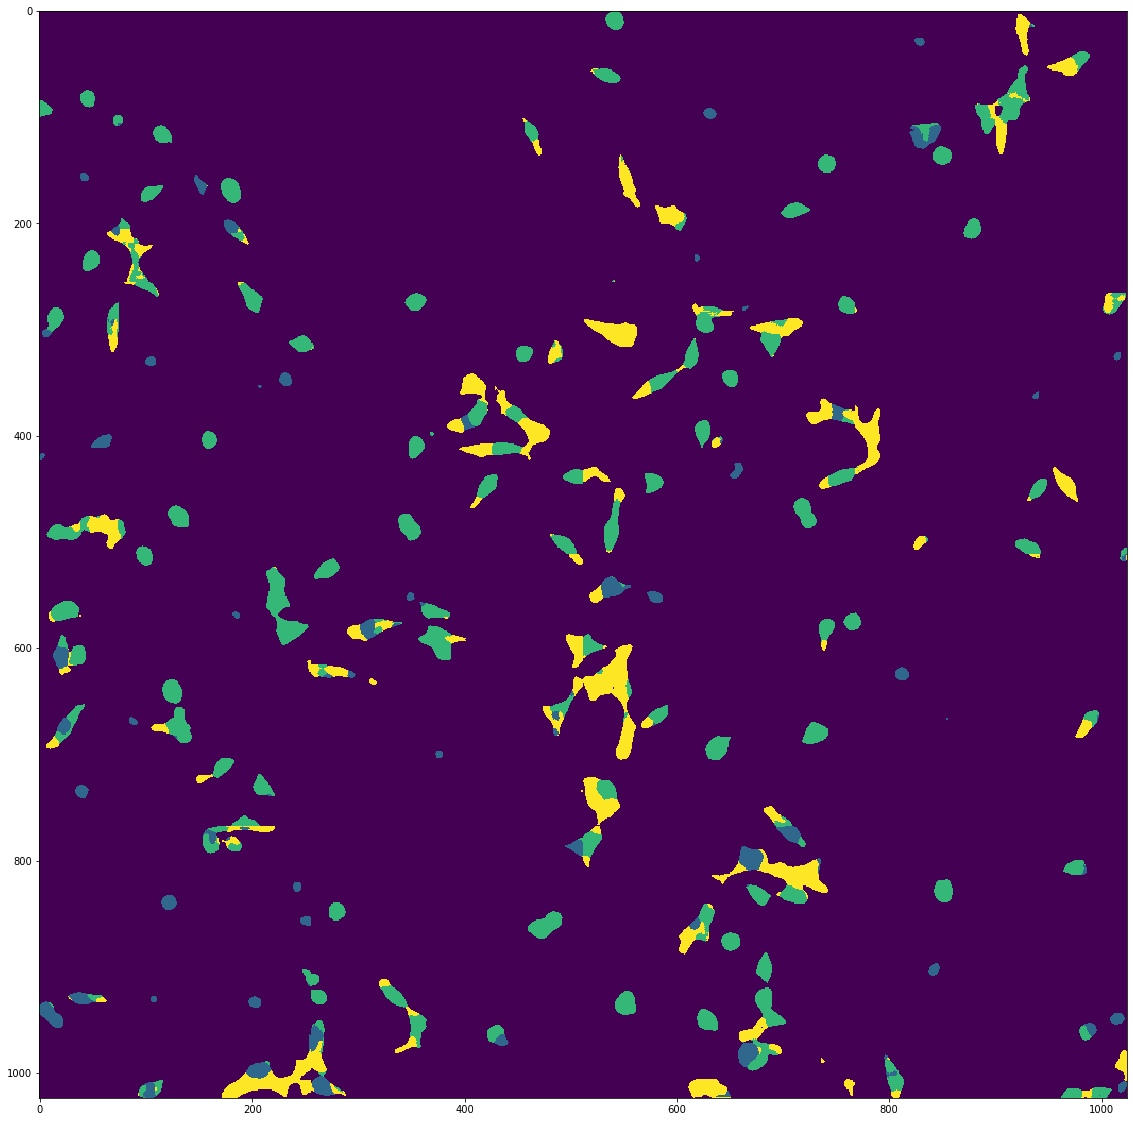

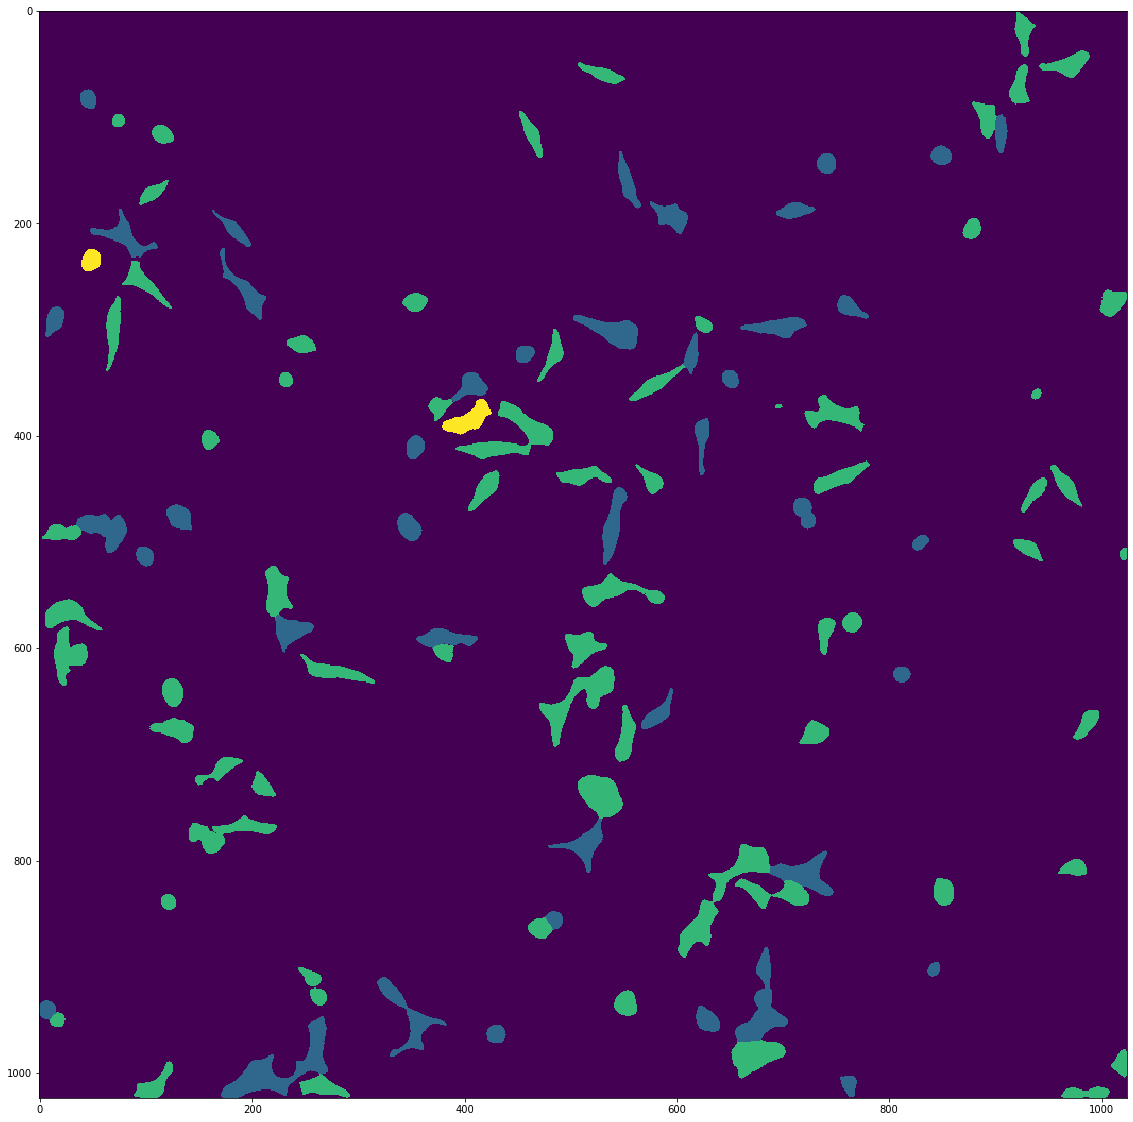

In [5]:
pred = zarr_file['pred_v1'][:]
gt = zarr_file['ground_truth'][:]

plt.figure(figsize = (20,20))
plt.imshow(pred[:,:,0])
plt.show()
plt.figure(figsize = (20,20))
plt.imshow(pred[:,:,1])
plt.show()
plt.figure(figsize = (20,20))
plt.imshow(pred[:,:,2])
plt.show()
plt.figure(figsize = (20,20))
plt.imshow(pred[:,:,3])
plt.show()
plt.figure(figsize = (20,20))
max_pred = pred.argmax(axis=2)
plt.imshow(max_pred)
plt.show()

plt.figure(figsize = (20,20))
max_gt = gt.argmax(axis=2)
plt.imshow(max_gt)
plt.show()

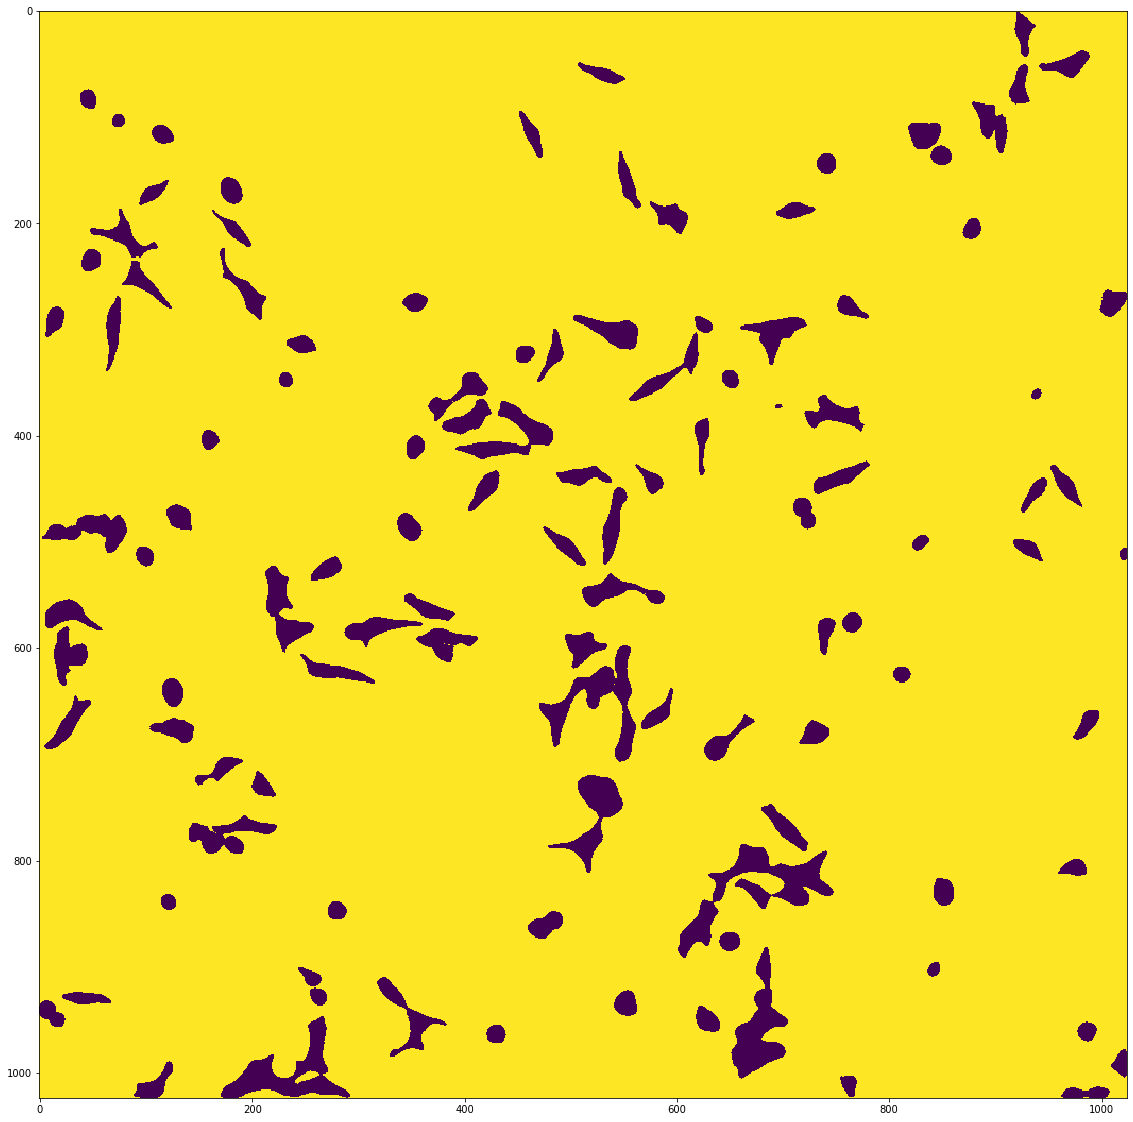

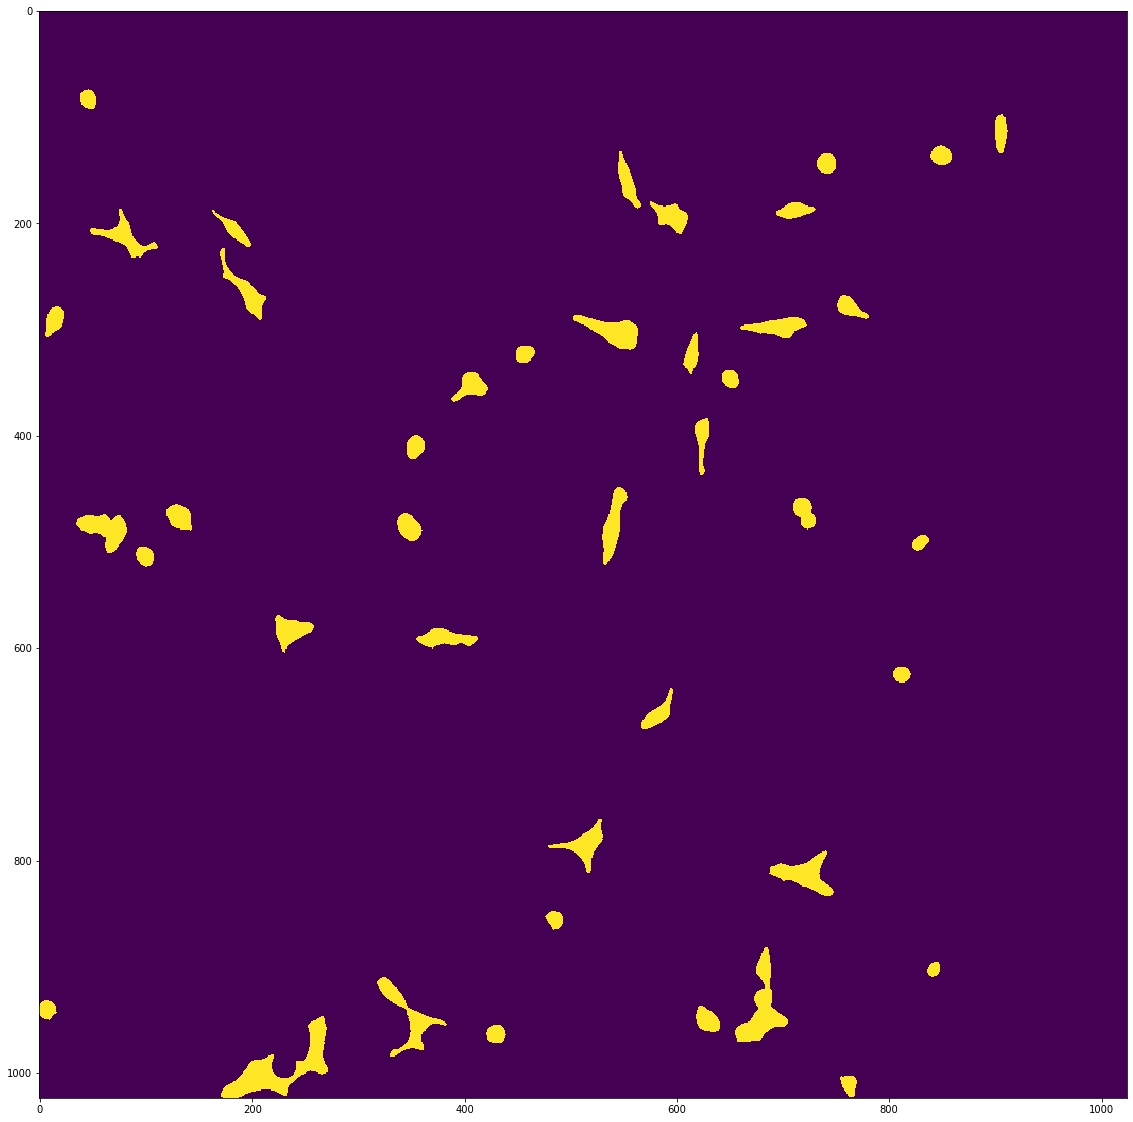

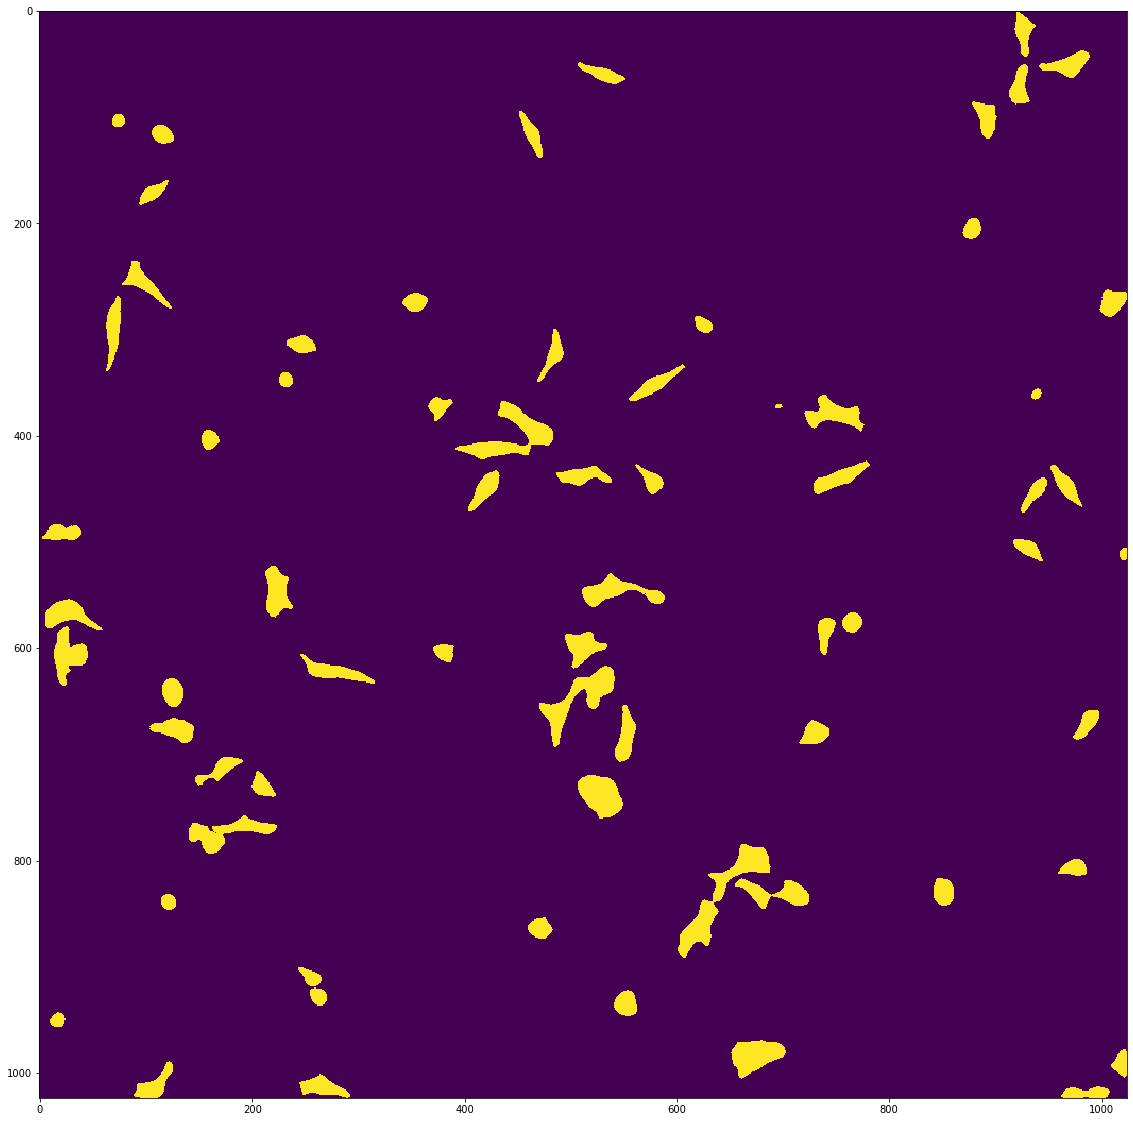

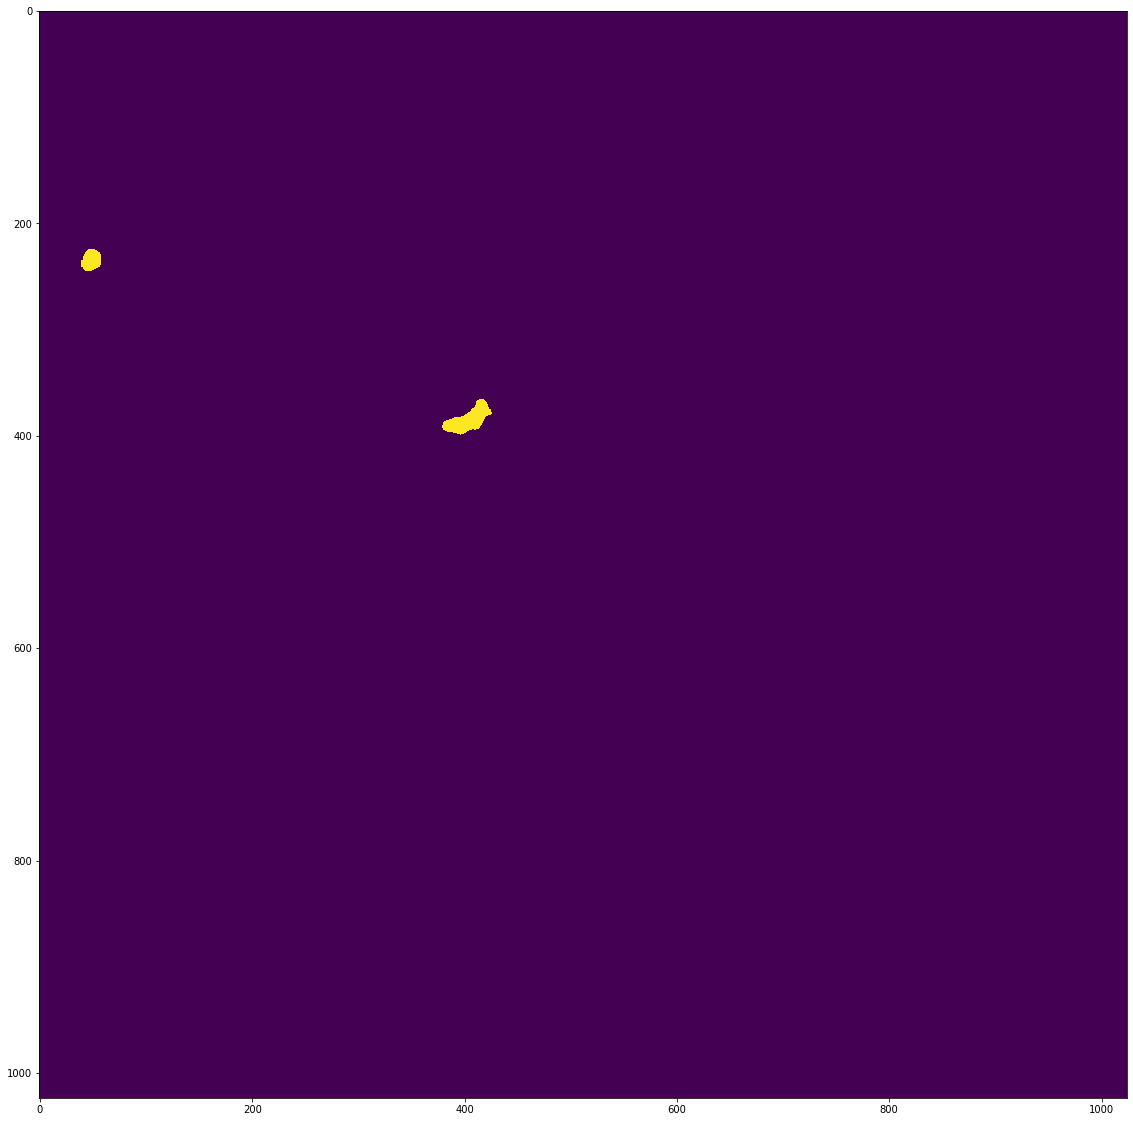

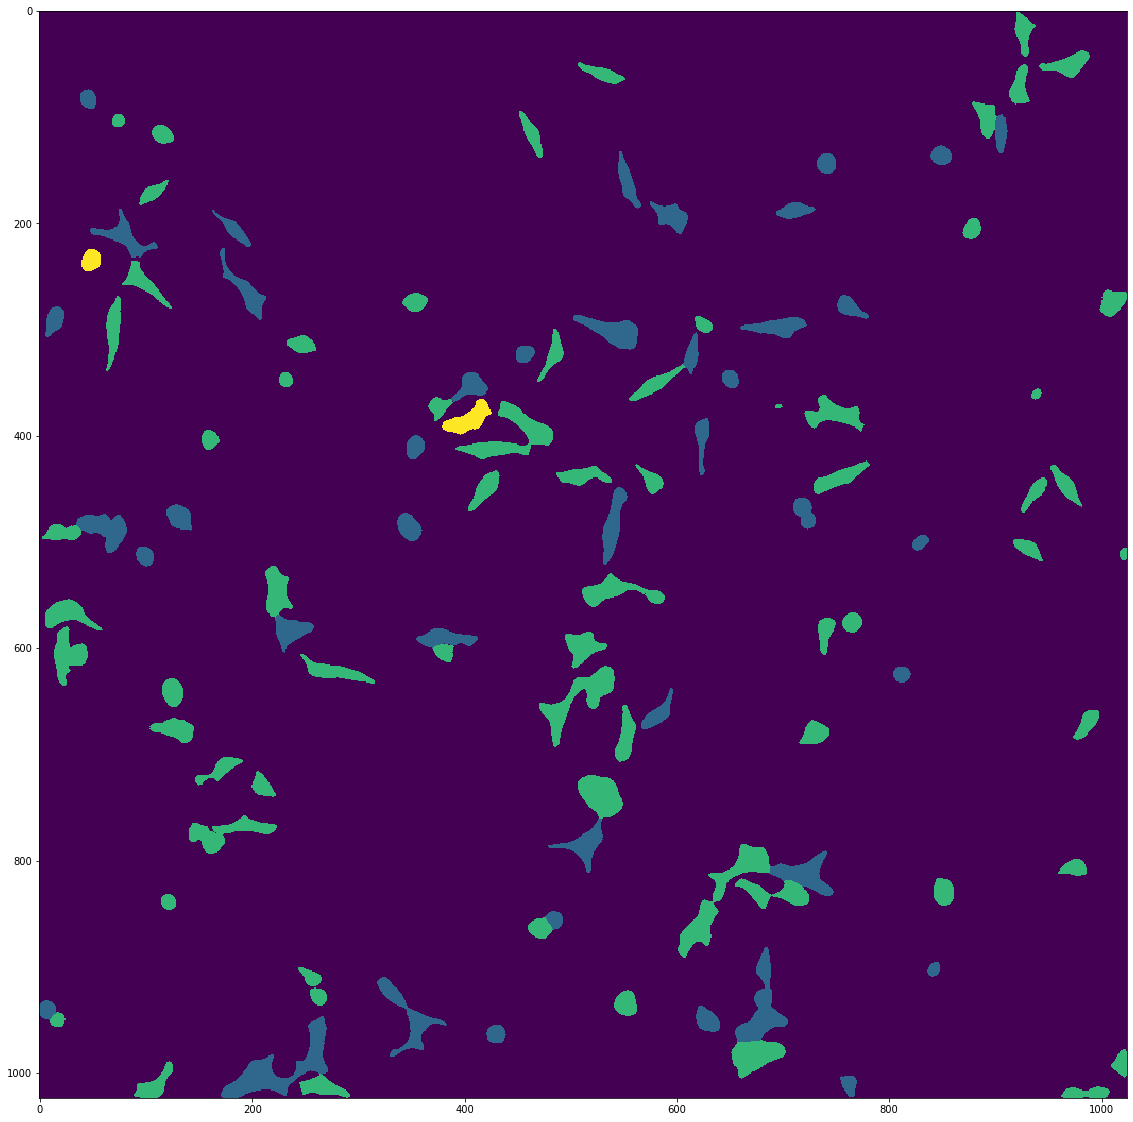

In [13]:
plt.figure(figsize = (20,20))
plt.imshow(gt[:,:,0])
plt.show()
plt.figure(figsize = (20,20))
plt.imshow(gt[:,:,1])
plt.show()
plt.figure(figsize = (20,20))
plt.imshow(gt[:,:,2])
plt.show()
plt.figure(figsize = (20,20))
plt.imshow(gt[:,:,3])
plt.show()

plt.figure(figsize = (20,20))
max_gt = gt.argmax(axis=2)
plt.imshow(max_gt)
plt.show()

(1024, 1024, 3)


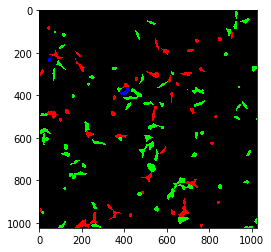

(1024, 1024)
Max masks: 149


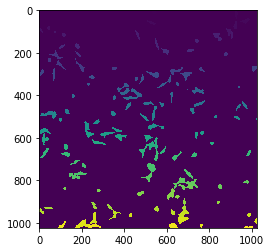

In [10]:
gt = zarr_file['ground_truth'][:]
gt = gt[:,:,1:4]
print(gt.shape)
plt.imshow(gt)
plt.show()
mask = zarr_file['instances'][:]
print(mask.shape)
print("Max masks: {}".format(mask.max()))
plt.imshow(mask)
plt.show()

### Mix data, Get the right category for each instance

In [12]:
import postproc 
import plot
from importlib import reload
import numpy as np
import sklearn.metrics as confusion
# confusion_matrix,plot_confusion_matrix
reload(postproc)
reload(plot)

<module 'plot' from '/tf/notebooks/PixelWise_Cell_Classification/V2/unet/plot.py'>

(1024, 1024)
[0. 1. 2. 3.]


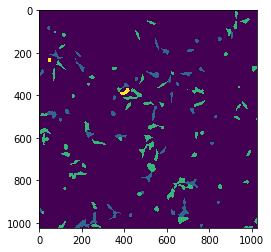

In [13]:
gt_sum = postproc.mix_channels(gt)
print(gt_sum.shape)
print(np.unique(gt_sum))
plt.imshow(gt_sum)

In [28]:
inst = 95
def keywithmaxval(d):
    if len(d) == 0:
        return -1
    v=list(d.values())
    k=list(d.keys())
    return k[v.index(max(v))]
# cat = postproc.get_prob_categories_per_instance(mask,max_pred,inst)
# print(cat)
l_pred = []
l_real = []
for i in range(1,mask.max()+1):
    pred = postproc.get_prob_categories_per_instance_v2(mask,max_pred,i,False)
    pred_max = keywithmaxval(pred)
    real = postproc.get_prob_categories_per_instance_v2(mask,gt_sum,i,False)
    real_max = keywithmaxval(real)
    if pred_max >=0:
        print('{}\t | {}-{} | {}'.format(pred_max == real_max,pred_max,real_max,pred[pred_max]))
    else: 
        print('{}\t | {}-{} '.format(pred_max == real_max,pred_max,real_max))
    l_pred.append(pred_max)
    l_real.append(real_max)

False	 | 2-0 | 0.8541666666666666
False	 | 3-2 | 0.738255033557047
False	 | 3-2 | 0.49421487603305786
True	 | 2-2 | 0.6216216216216216
True	 | 2-2 | 0.7880085653104925
False	 | 2-1 | 0.7991266375545851
False	 | 2-0 | 0.5160142348754448
True	 | 2-2 | 0.6378600823045267
True	 | 2-2 | 0.5537190082644629
False	 | 3-1 | 0.8323170731707317
True	 | 2-2 | 0.8
True	 | 2-2 | 0.4387254901960784
False	 | 1-0 | 0.5812101910828026
False	 | 2-1 | 0.8685121107266436
False	 | 2-1 | 0.8133802816901409
False	 | 3-1 | 0.818
False	 | 2-0 | 0.8463414634146341
True	 | 2-2 | 0.6742671009771987
False	 | 2-1 | 0.7131578947368421
False	 | 3-1 | 0.6301369863013698
True	 | 1-1 | 0.375
True	 | 2-2 | 0.9245283018867925
False	 | 3-1 | 0.4360248447204969
False	 | 2-3 | 0.8122977346278317
True	 | 2-2 | 0.535472972972973
False	 | 0-1 | 0.5141318977119784
True	 | 2-2 | 0.7854889589905363
False	 | 3-2 | 0.3574468085106383
False	 | 2-1 | 0.5911602209944752
True	 | 0-0 | 0.5099236641221374
False	 | 2-1 | 0.7408450704225352


In [30]:
acc1 = 0
total1 = 0
acc2 = 0 
total2 = 0
for i in range(1024):
    for j in range(1024):
        if gt_sum[i][j] > 0:
            total2 = total2+1
            if max_pred[i][j] == gt_sum[i][j]:
                acc2 = acc2+1
        total1 = total1+1
        if max_pred[i][j] == gt_sum[i][j]:
                acc1 = acc1+1
print(acc1/total1)
print(acc2/total2)

0.9478693008422852
0.26900083963056254


In [15]:
mask = zarr_file['instances'][:]
categories_per_instances = postproc.get_categories_map_per_instances(mask,max_pred,gt=gt_sum,threshold=0.6)
print(type(categories_per_instances))
print(categories_per_instances)

0.49 - 3: 2 
0.52 - 2: 0 
0.55 - 2: 2 
0.44 - 2: 2 
0.58 - 1: 0 
0.38 - 1: 1 
0.44 - 3: 1 
0.54 - 2: 2 
0.51 - 0: 1 
0.36 - 3: 2 
0.59 - 2: 1 
0.51 - 0: 0 
0.36 - 0: 2 
0.50 - 0: 2 
0.51 - 2: 2 
0.59 - 0: 2 
0.59 - 3: 2 
0.40 - 2: 3 
0.59 - 3: 2 
0.46 - 3: 2 
0.37 - 3: 2 
0.44 - 2: 2 
0.55 - 2: 2 
0.54 - 2: 1 
0.50 - 3: 1 
0.52 - 2: 0 
0.53 - 2: 2 
0.42 - 0: 2 
0.48 - 2: 0 
0.49 - 2: 2 
0.34 - 0: 0 
0.55 - 2: 1 
0.48 - 3: 2 
0.38 - 1: 2 
0.44 - 3: 2 
0.37 - 3: 2 
0.45 - 2: 1 
0.38 - 2: 0 
0.45 - 3: 2 
0.53 - 2: 2 
0.55 - 3: 2 
0.39 - 2: 2 
0.34 - 1: 0 
0.53 - 0: 2 
0.36 - 2: 0 
0.38 - 2: 1 
0.38 - 0: 2 
0.38 - 3: 2 
0.47 - 1: 0 
0.43 - 2: 1 
0.38 - 0: 1 
0.40 - 2: 0 
0.52 - 3: 1 
0.35 - 0: 2 
0.59 - 0: 1 
0.48 - 0: 2 
0.46 - 1: 2 
<class 'list'>
[2, 3, -1, 2, 2, 2, -1, 2, -1, 3, 2, -1, -1, 2, 2, 3, 2, 2, 2, 3, -1, 2, -1, 2, -1, -1, 2, -1, -1, -1, 2, 2, 3, -1, 3, 2, 2, 2, -1, 2, 1, 2, 3, -1, -1, 0, 0, -1, -1, -1, 2, -1, 2, 2, -1, -1, -1, 2, 3, -1, 2, 2, 2, 2, 3, -1, 2, 2, 2, -1, 3, -1, 

<class 'list'>
[0, 0, 0, 0, 0, 3, 0, 2, 2, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 2, 2, 2, 3, 2, 3, 2, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 3, 2, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 0, 3, 2, 3, 3, 3, 0, 2, 3, 2, 2, 2, 3, 2, 2, 1, 3, 0, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 2, 2, 0, 3, 3, 3, 2, 3, 3, 3, 0, 2, 3, 0, 2, 3, 2, 0, 2, 0, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 2, 3, 3, 3, 3, 2, 3, 3, 2, 2, 3, 3, 3, 2, 2, 1, 3, 3, 3, 3, 0, 3, 3, 1, 3, 2, 3, 3, 2, 2, 3, 3, 0, 3, 3, 2, 2, 2, 2, 3, 2, 1, 1, 1, 1, 1]


In [159]:
conf_mtx = confusion.confusion_matrix(categories_per_instances_qt, categories_per_instances )

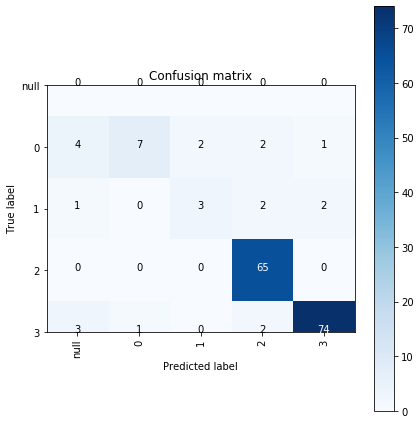

In [166]:
plot.plot_confusion_matrix(confusion_matrix,  classes=['null','0','1','2','3']) 

In [ ]:
def generateCategoryImagefromList(path_instance_image,list_inst):
#     data = pd.read_csv(path_csv) 
    img = read_img(path_instance_image)
    result = np.zeros_like(img)
    for i,val in enumerate(list_inst):
        result = result + (img==(i+1))*val
    return result

In [40]:
PREDS = ['pred_v1', 'pred_v2', 'pred_v3', 'pred_v4', 'pred_v5', 'pred_v6']

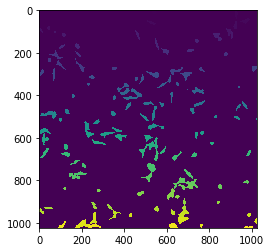

In [42]:
mask = zarr_file['instances'][:]
plt.imshow(mask)

In [43]:
categories_prediction = []
for prediction in PREDS:
    print(prediction)
    # Get image
    pred = zarr_file[prediction][:]
    # get max per pixel
    max_pred = pred.argmax(axis=2)
    # get max per instance list
    categories_per_instances = postproc.get_categories_map_per_instances(mask,max_pred,gt=gt_sum,threshold=0.6)
    
    categories_prediction.append(categories_per_instances)
    # get matrix
    
    

pred_v1
0.49 - 3: 3 
0.52 - 2: 1 
0.55 - 2: 3 
0.44 - 2: 3 
0.58 - 1: 0 
0.38 - 1: 2 
0.44 - 3: 2 
0.54 - 2: 3 
0.51 - 0: 2 
0.36 - 3: 3 
0.59 - 2: 2 
0.51 - 0: 1 
0.36 - 0: 3 
0.50 - 0: 3 
0.51 - 2: 3 
0.59 - 0: 3 
0.59 - 3: 3 
0.40 - 2: 4 
0.59 - 3: 3 
0.46 - 3: 3 
0.37 - 3: 3 
0.44 - 2: 3 
0.55 - 2: 3 
0.54 - 2: 2 
0.50 - 3: 2 
0.52 - 2: 0 
0.53 - 2: 3 
0.42 - 0: 3 
0.48 - 2: 0 
0.49 - 2: 3 
0.34 - 0: 0 
0.55 - 2: 2 
0.48 - 3: 3 
0.38 - 1: 3 
0.44 - 3: 3 
0.37 - 3: 3 
0.45 - 2: 2 
0.38 - 2: 0 
0.45 - 3: 3 
0.53 - 2: 3 
0.55 - 3: 3 
0.39 - 2: 3 
0.34 - 1: 0 
0.53 - 0: 3 
0.36 - 2: 0 
0.38 - 2: 2 
0.38 - 0: 3 
0.38 - 3: 3 
0.47 - 1: 0 
0.43 - 2: 2 
0.38 - 0: 2 
0.40 - 2: 0 
0.52 - 3: 2 
0.35 - 0: 3 
0.59 - 0: 2 
0.48 - 0: 3 
0.46 - 1: 3 
pred_v2
pred_v3
0.60 - 2: 3 
0.60 - 2: 1 
0.59 - 2: 2 
0.46 - 2: 0 
0.55 - 2: 2 
0.48 - 2: 3 
0.58 - 3: 2 
0.56 - 2: 2 
0.30 - 0: 2 
0.36 - 0: 3 
0.48 - 0: 2 
0.50 - 2: 3 
0.54 - 0: 1 
0.45 - 3: 2 
0.46 - 2: 3 
0.50 - 0: 3 
0.39 - 2: 2 
0.51 - 1: 3 
0

In [45]:
categories_per_instances_qt = postproc.get_categories_map_per_instances(mask,gt_sum)
print(type(categories_per_instances_qt))
print(categories_per_instances_qt)

<class 'list'>
[1, 3, 3, 3, 3, 2, 1, 3, 3, 2, 3, 3, 0, 2, 2, 2, 0, 3, 2, 2, 2, 3, 2, 4, 3, 2, 3, 3, 2, 1, 2, 3, 2, 3, 2, 0, 3, 2, 3, 2, 3, 2, 2, 3, 3, 3, 3, 3, 4, 3, 2, -1, 3, 2, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 0, 3, 3, 2, 0, 3, 3, 3, 0, 3, 3, 0, 2, 3, 2, 3, 3, 3, 3, 3, 2, 3, 0, 3, 3, 2, 0, 3, 3, 3, 3, 0, 3, 3, 3, 3, 0, 3, 0, 2, 3, 3, 2, 3, 3, 3, 3, 0, 2, 3, 3, 0, 2, 2, 3, 2, 3, 0, 2, 3, 2, 3, 2, 2, 2, 0, 2, 2, 3, 3, 2, 2, 3, 3, 1, 0, 3, 3]


In [46]:
all_matrix = []
for x in categories_prediction:
    conf_mtx = confusion.confusion_matrix(categories_per_instances_qt, x )
    all_matrix.append(conf_mtx)

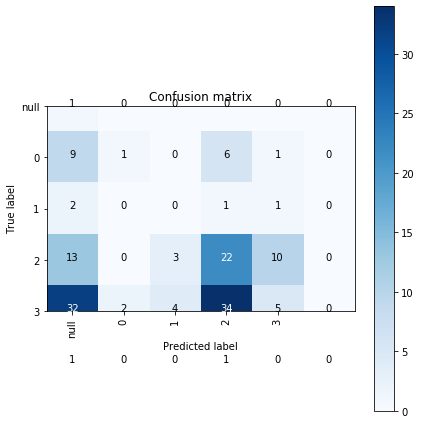

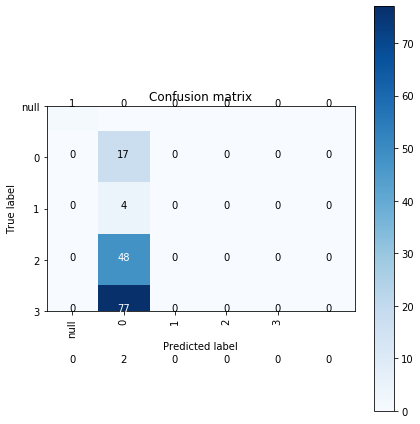

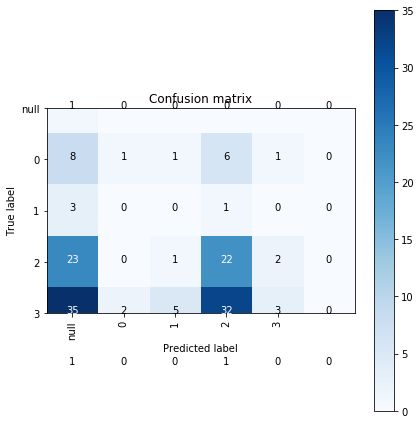

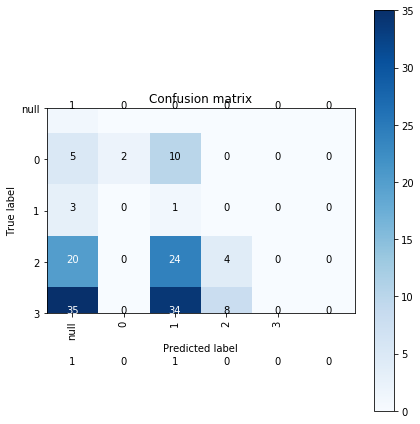

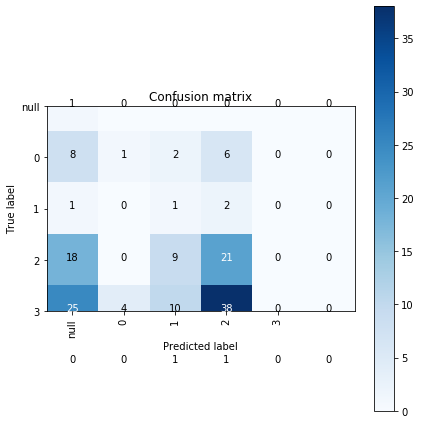

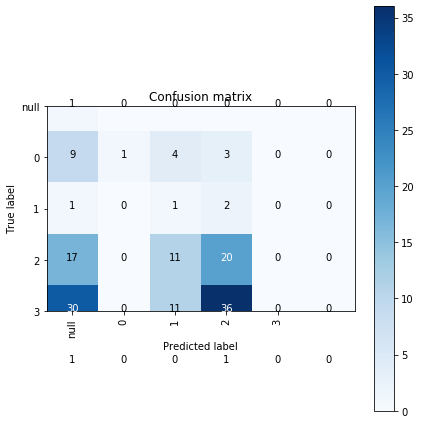

In [47]:
for x in all_matrix:
    plot.plot_confusion_matrix(x,  classes=['null','0','1','2','3']) 
    plt.show()

In [54]:
acc = []
for prediction in PREDS:
    print(prediction)
    # Get image
    pred = zarr_file[prediction][:]
    # get max per pixel
    max_pred = pred.argmax(axis=2)
    gt = zarr_file['ground_truth'][:]
    max_gt = gt.argmax(axis=2)
    
#     equ = (max_pred==max_gt)
    
    print(np.unique(max_pred))
    print(np.unique(max_gt))
    


pred_v1
[0 1 2 3]
[0 1 2 3]
pred_v2
[0]
[0 1 2 3]
pred_v3
[0 1 2 3]
[0 1 2 3]
pred_v4
[0 1 2 3]
[0 1 2 3]
pred_v5
[0 1 2 3]
[0 1 2 3]
pred_v6
[0 1 2]
[0 1 2 3]
